# Calculating Temporal Averages with GeoCAT-comp vs Xarray

With temporally large datasets, computing seasonal and annual averages are a great ways to summarize the data and make it easier to manage and understand. You may want to take hourly, daily, or monthly data and compute seasonal (3 month time spans) or annual averages.

## Challenges
When using data that has a daily or finer resolution (e.g. hourly), calculating an annual average is simple. Every day and hour has the same length, so an unweighted average will work.

But when using data that is monthly, things can get a bit tricky. Not every month is created equal. February has 28 or 29 days and March has 31 days. Since monthly data has one value for each month, those points can't be averaged in the usual way. A weighted average is needed.

While it is tempting to quickly compute monthly to annual averages with `Xarray`'s `resample` or `groupby` functions, we need to be careful to specify the weights. Unfortunately, `Xarray` doesn't support weighted `resample` or `groupby` at the time this post was created.

Below is a plot showing the difference between computing an annual average from monthly data using the incorrect unweighted average and the correct weighted average.

# ADD PLOT

### Imports

In [1]:
import numpy as np
import xarray as xr
import nc_time_axis
import geocat.comp as gc
import zarr

### Helper function to make all of the plots the same way but with different data

In [9]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geocat.viz as gv

def custom_plot(data, title):
    # Generate figure (set its size (width, height) in inches)
    plt.figure(figsize=(14, 7))

    # Generate axes, using Cartopy
    projection = ccrs.PlateCarree()
    ax = plt.axes(projection=projection)

    # Use global map and draw coastlines
    ax.set_global()
    ax.coastlines()

    # Contourf-plot data (for filled contours)
    p = data.plot.contourf(ax=ax, vmin=-10, vmax=35, levels=16, cmap='inferno',
                        add_colorbar=False, transform=projection, extend='neither')

    # Add horizontal colorbar
    cbar = plt.colorbar(p, orientation='horizontal', shrink=0.5)
    cbar.ax.tick_params(labelsize=14)
    cbar.set_ticks(np.linspace(-10, 35, 14))

    # Use geocat.viz.util convenience function to set axes tick values
    gv.set_axes_limits_and_ticks(ax,
                                 xticks=np.linspace(-180, 180, 13),
                                 yticks=np.linspace(-90, 90, 7))

    # Use geocat.viz.util convenience function to make plots look like NCL plots by using latitude, longitude tick labels
    gv.add_lat_lon_ticklabels(ax)

    # Use geocat.viz.util convenience function to add minor and major tick lines
    gv.add_major_minor_ticks(ax, labelsize=12)

    # Use geocat.viz.util convenience function to add titles to left and right of the plot axis.
    gv.set_titles_and_labels(ax, maintitle=title,
                             lefttitle=data.long_name, lefttitlefontsize=16,
                             righttitle=data.units, righttitlefontsize=16,
                             xlabel="", ylabel="")

    # Show the plot
    plt.show()

### Read in and format data

In [3]:
ds = xr.open_zarr(
    's3://ncar-cesm2-lens/ocn/monthly/cesm2LE-ssp370-cmip6-TEMP.zarr',
    storage_options={'anon': True},
)
# Get the first 5 years of data to reduce computation time
ds_first_five_years = ds.sel(time=slice('2015', '2019')).isel(member_id=1)

ds_first_five_years

<xarray.Dataset>
Dimensions:     (time: 60, z_t: 60, nlat: 384, nlon: 320, d2: 2)
Coordinates:
    member_id   <U12 'r10i1231p1f1'
  * time        (time) object 2015-01-16 12:00:00 ... 2019-12-16 12:00:00
    time_bound  (time, d2) object dask.array<chunksize=(60, 2), meta=np.ndarray>
  * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    TEMP        (time, z_t, nlat, nlon) float32 dask.array<chunksize=(6, 60, 384, 320), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    calendar:          All years have exactly  365 days.
    cell_methods:      cell_methods = time: mean ==> the variable values are ...
    contents:          Diagnostic and Prognostic Variables
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    revision:          $Id$
    source:            CCSM POP2, the CCSM Ocean Component
    time_period_freq:  month_1

### The incorrect way to compute seasonal averages from monthly data

It's easy to compute and unweighted average using `xarray` functionality; however, this generates inaccurate results. Here is what the ***incorrect*** way of doing this looks like.

In [4]:
seasonal_average_weighted_incorrectly = ds_first_five_years.resample(time='QS-DEC').mean().groupby('time.month').mean()
seasonal_average_weighted_incorrectly

<xarray.Dataset>
Dimensions:    (month: 4, z_t: 60, nlat: 384, nlon: 320)
Coordinates:
    member_id  <U12 'r10i1231p1f1'
  * z_t        (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * month      (month) int64 3 6 9 12
Dimensions without coordinates: nlat, nlon
Data variables:
    TEMP       (month, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 60, 384, 320), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    calendar:          All years have exactly  365 days.
    cell_methods:      cell_methods = time: mean ==> the variable values are ...
    contents:          Diagnostic and Prognostic Variables
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    revision:          $Id$
    source:            CCSM POP2, the CCSM Ocean Component
    time_period_freq:  month_1

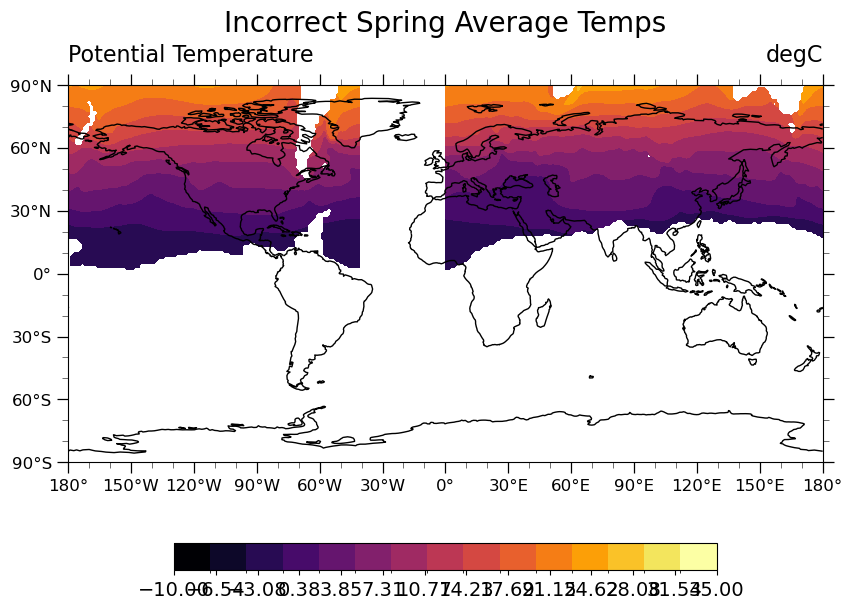

In [11]:
custom_plot(seasonal_average_weighted_incorrectly.TEMP.isel(z_t=0, month=0), "Incorrect Spring Average Temps")

### The correct way to compute seasonal averages with xarray
Using GeoCAT's climatology average, we can calculate the average potential temperature for each season during the 5 years our data covers. We do need to format the data before using it. `climatology_average` requires that the datetime objects for the time dimension are evenly spaced. We can use `xarray.DataArray.resample` to make sure the monthly data has dates at the start of each month rather than in the center of the months.

In [14]:
# What the time dimension looks like before resampling
ds_first_five_years['time']

<xarray.DataArray 'time' (time: 60)>
array([cftime.DatetimeNoLeap(2015, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 4, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 5, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 6, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 7, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 8, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 9, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 12, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2016, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2016, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2016, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2016, 4, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2016, 5, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2016, 6, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2016, 7, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2016, 8, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2016, 9, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2016, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2016, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2016, 12, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2017, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2017, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2017, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2017, 4, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2017, 5, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2017, 6, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2017, 7, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2017, 8, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2017, 9, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2017, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2017, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2017, 12, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 4, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 5, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 6, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 7, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 8, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 9, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 12, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2019, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2019, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2019, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2019, 4, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetim

In [22]:
# What the time dimesnion looks like after resampling. The call to mean describes how to 
# agregate the data, but we know that we only have one data point per month. We are just
# changing the day for the datetime objects.
ds_resample = ds_first_five_years.resample(time='MS').mean()
ds_resample

<xarray.Dataset>
Dimensions:    (time: 60, z_t: 60, nlat: 384, nlon: 320)
Coordinates:
    member_id  <U12 'r10i1231p1f1'
  * z_t        (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * time       (time) object 2015-01-01 00:00:00 ... 2019-12-01 00:00:00
Dimensions without coordinates: nlat, nlon
Data variables:
    TEMP       (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 60, 384, 320), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    calendar:          All years have exactly  365 days.
    cell_methods:      cell_methods = time: mean ==> the variable values are ...
    contents:          Diagnostic and Prognostic Variables
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    revision:          $Id$
    source:            CCSM POP2, the CCSM Ocean Component
    time_period_freq:  month_1

In [23]:
seasonal_average_weighted_correctly = gc.climatology_average(ds_resample, 'season')
seasonal_average_weighted_correctly

TypeError: '.dt' accessor only available for DataArray with datetime64 timedelta64 dtype or for arrays containing cftime datetime objects.

In [ ]:
custom_plot(seasonal_average_weighted_correctly.TEMP.isel(z_t=0, time=0), 'Correct Sping Average Temps')

## So what's the difference?
It is hard to see the difference between the correct and incorrect ways of caluclating the seasonal averages. If we plot the difference between the two results, the computational errors become easier to see.

In [ ]:
diff = seasonal_average_weighted_correctly - seasonal_average_weighted_incorrectly
diff.max()